In [1]:
# Check if jupyter is using virtual env created
import sys
print(sys.executable)

/opt/anaconda3/bin/python


In [3]:
!pip install pymc3

     |████████████████████████████████| 908 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 14.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 38.3 MB/s eta 0:00:01
     |████████████████████████████████| 6.4 MB 18.3 MB/s eta 0:00:01
     |████████████████████████████████| 668 kB 29.5 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 23.3 MB/s eta 0:00:01
  Created wheel for theano: filename=Theano-1.0.4-py3-none-any.whl size=2667177 sha256=92526f47551c24ba7bf4fc3fc93c83e4e1cab174a3dbb45bee766dc1fdea5b5a
  Stored in directory: /Users/shinde/Library/Caches/pip/wheels/33/e0/86/12647586a15bd29c062c9996231380908fb2dcf6a5df1c6f84
Successfully built theano


In [8]:
import pymc3 as pm
import numpy as np
import pandas as pd
%matplotlib inline

# Customer Lifetime Value Modeling in Python
## A Tutorial Using Probabalistic Programming and PyMC
by Ben Van Dyke and Jean-Rene Gauthier, [DataScience.com](https://datascience.com)

## Table of Contents

### [Introduction](#introduction)

### [Dataset](#dataset)

### [Model Implementation](#model-implementation)

### [Model Checking](#model-checking)

### [Further Reading](#further-reading)


<a id="introduction"></a>
## Introduction

This notebook contains a Python implementation of the Pareto/NBD customer lifetime value model using the [PyMC](https://github.com/pymc-devs/pymc3) probabilistic machine learning package. First developed in the 1980's, this model has become widely cited in the literature and generally performs well in a transactional setting.

### Setup

We provide a [conda](https://conda.io/docs/index.html) environment file for generating an environment suitable for loading the data and fitting the model.

If you have conda installed, you can create a Python 3 environment from the provided file with the following command (assuming your working directory is the `lifetime-value` directory in this repo).

```
    conda env create --file environment.yml
```

### Python and R Packages for Lifetime Value Analysis

[Cam-Davidson Pilon](https://github.com/CamDavidsonPilon) has contributed a Python library called [Lifetimes](https://github.com/CamDavidsonPilon/lifetimes) which contains Python implementations of many LTV models. It is inspired by the R package [BTYD](https://cran.r-project.org/web/packages/BTYD/index.html) which contains contributions from leading CLV researchers Peter Fader and Bruce Hardie. Michael Platzer has extended BTYD with his package [BTYDplus](https://cran.r-project.org/web/packages/BTYDplus/index.html) with additional models in the literature including the hierarchical extension proposed by Abe. 

### Why Probabilistic Programming and PyMC?

Lifetimes and BTYD both implement traditional analytical approaches to model fitting that take advantage of conjugacy in prior specification. The analytical approach requires some complex mathematics including evaluation of the Guassian hypergeometric function for the integral of the likelihood function. Probabilistic programming packages such as PyMC and [Stan](https://mc-stan.org) allow us to calculate these integrals via Markov chain Monte Carlo and give us more flexibility in prior specification as we are no longer limited by conjugacy. In addition, the Markov chain yields the full posterior distributions for model parameters and hyperparameters. We can then express our key quantities such as predicted purchases as distributions rather than point estimates. This provides insight into our level of uncertainty in our predictions.

<a id='dataset'></a>
## Dataset

The [CDNOW](https://en.wikipedia.org/wiki/CDNow) dataset is a standard dataset used to benchmark and compare transactional lifetime value models. Bruce Hardie wrote a [technical note](http://www.brucehardie.com/notes/026/) on the dataset and the 1/10th sample frequently used in the literature. 

Lifetimes provides a utility function for loading the dataset of CDNOW customer transactions into a pandas dataframe. 

In [6]:
!pip install lifetimes

  Using cached Lifetimes-0.11.1-py2.py3-none-any.whl (581 kB)
  Using cached autograd-1.3.tar.gz (38 kB)
  Using cached dill-0.3.1.1.tar.gz (151 kB)
  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47990 sha256=74366593900e35ab2f9e5cf256552e968e0bf367e3e081549359f6c6201a5415
  Stored in directory: /Users/shinde/Library/Caches/pip/wheels/ef/32/31/0e87227cd0ca1d99ad51fbe4b54c6fa02afccf7e483d045e04
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78530 sha256=058e24bd09a9c30833b1fb441b2129284bf4d02db8815da56eafab8c50f859ed
  Stored in directory: /Users/shinde/Library/Caches/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
Successfully built autograd dill


In [9]:
from lifetimes.datasets import load_dataset

cdnow_transactions = load_dataset(
                'CDNOW_sample.txt', 
                header=None, 
                delim_whitespace=True, 
                names=['customer_id', 'customer_index', 'date', 'quantity', 'amount'],
                converters={'date': lambda x: pd.to_datetime(x, format="%Y%m%d")}
                )
    
cdnow_transactions.head()

,customer_id,customer_index,date,quantity,amount
0,4,1,1997-01-01,2,29.33
1,4,1,1997-01-18,2,29.73
2,4,1,1997-08-02,1,14.96
3,4,1,1997-12-12,2,26.48
4,21,2,1997-01-01,3,63.34


In [10]:
cdnow_transactions.shape

(6919, 5)

One of the advantages of the Pareto/NBD and similar lifetime value models is the small amount of required data to generate an effective result. From a transaction log like above, it is easy to generate a <a href="https://en.wikipedia.org/wiki/RFM_(customer_value)">recency-frequency matrix</a> used by the Pareto/NBD model. 

* *frequency*: number of repeat purchases
* *recency*: time of most recent purchase
* *T*: total elapsed time since customer's first purchase

The standard training period for the CDNOW dataset runs from January 1, 1997 through September 30, 1997. The following period spanning October 1, 1997 through June 30, 1998 is typically used to evaluate a model's out-of-sample performance. 

In [12]:
import lifetimes

In [22]:
sample_cust = cdnow_transactions[cdnow_transactions['customer_id'] == 18]
sample_cust = sample_cust.sort_values(by = 'date')
sample_cust

,customer_id,customer_index,date,quantity,amount
157,18,58,1997-01-04,1,14.96


In [13]:
# lifetimes provides a transaction log -> rfm util function
rfm = lifetimes.utils.summary_data_from_transaction_data(
                                    cdnow_transactions,
                                    'customer_id',
                                    'date',
                                    observation_period_end=pd.to_datetime('1997-09-30'),
                                    freq='W'
                                    )

rfm.head()

,frequency,recency,T
customer_id,,,
4,2.0,30.0,39.0
18,0.0,0.0,39.0
21,1.0,2.0,39.0
50,0.0,0.0,39.0
60,0.0,0.0,35.0


In [18]:
rfm.nunique()

frequency    18
recency      40
T            13
dtype: int64

<a id='model-implementation'></a>
## Model Implementation

#### Purchasing Rate

The number of purchases made in a period $t$ follows a Poisson distribution:

$$ p(x~|~\lambda, \Delta t ) =  \frac{(\lambda \Delta t)^x}{x!} e^{-\lambda \Delta t} $$ 

Purchasing rate parameter $\lambda$ is distributed Gamma with parameters $r$ and $alpha$:

$$\lambda \sim \Gamma(r, \alpha)$$

A customer with a transaction rate $\lambda$ will make on average $\lambda \times \Delta t$ transactions in a period of time $\Delta t$.

#### Lifetime

At the customer level, the lifetime $\tau$ is distributed according to an exponential distribution

$$ p(\tau~|~\mu) = \mu e^{-\mu \tau } $$ 

where $\tau > 0$. In other words, each customer has its own lifetime distribution. Note that the expectation value for the lifetime $\tau$ is $E[\tau~|~\mu] = \frac{1}{\mu}$. 

The value of $\mu$ varies across the customers according to another gamma distribution with shape $s$ and rate $\beta$ : 

$$\mu \sim \Gamma(s, \beta)$$

#### Likelihood

Likelihood for an individuals purchasing rate and lifetime conditional on purchasing frequency, recency, and time since initial purchase:

$$ L(\lambda, \mu~|~x,t_x,T) = \frac{\lambda^x \mu}{\lambda+\mu}e^{-(\lambda+\mu)t_x}+\frac{\lambda^{x+1}}{\lambda+\mu}e^{-(\lambda+\mu)T} $$

where $x$ is the repeat purchase frequency, $t_x$ is the recency and $T$ is the length of the calibration/training period. 


### PyMC Implementation

To implement the model in PyMC, we'll need to create a custom distribution to express the likelihood function. This can be accomplished by creating a new `ParetoNBD` class that inherits from the base `pymc3.Continuous` class. We simply add the parameterization to the constructor and implement a log-likelihood function. 

In [23]:
# import theano 
from pymc3.math import exp, log

class ParetoNBD(pm.Continuous):
    """
    Custom distribution class for Pareto/NBD likelihood.
    """
    
    def __init__(self, lambda_, mu, *args, **kwargs):
        super(ParetoNBD, self).__init__(*args, **kwargs)
        self.lambda_ = lambda_
        self.mu = mu
        
    def logp(self, x, t_x, T):
        """
        Loglikelihood function for and indvidual customer's purchasing rate \lambda
        and lifetime \mu given their frequency, recency and time since first purchase.
        """
        
        log_lambda = log(self.lambda_)
        log_mu = log(self.mu)
        mu_plus_lambda = self.lambda_ + self.mu
        log_mu_plus_lambda = log(mu_plus_lambda)
        
        p_1 = x * log_lambda + log_mu - log_mu_plus_lambda - t_x * mu_plus_lambda
        p_2 = (x + 1) * log_lambda - log_mu_plus_lambda - T * mu_plus_lambda
        
        return log(exp(p_1) + exp(p_2))

Now we're ready to specify the model. We extract data from the RFM and name variables following the convention in the literature. We place positive-bounded, non-informative priors on the $r$, $\alpha$, $s$, and $\beta$ hyperparameters.

In [24]:
# Extract data for model following notation from Fader/Hardie
N = rfm.shape[0] # number of customers
x = rfm['frequency'].values
t_x = rfm['recency'].values
T = rfm['T'].values # length of training period

n_draws = 2000

pnbd_model = pm.Model()

with pnbd_model:
    
    # Uninformative priors on model hyperparameters see Polson and Scott 
    # https://projecteuclid.org/download/pdfview_1/euclid.ba/1354024466
    r = pm.HalfCauchy('r', beta=2)
    alpha = pm.HalfCauchy('alpha', beta=2)
    s = pm.HalfCauchy('s', beta=2)
    beta = pm.HalfCauchy('beta', beta=2)
    
    # Gamma prior on purchasing rate parameter lambda
    lambda_ = pm.Gamma('lambda', alpha=r, beta=alpha, shape=N, testval=np.random.rand(N))
    # Gamma prior on lifetime parameter mu
    mu = pm.Gamma('mu', alpha=s, beta=beta, shape=N, testval=np.random.rand(N))

    # Custom distribution for Pareto-NBD likelihood function
    loglikelihood = ParetoNBD("loglikelihood", mu=mu, lambda_=lambda_, observed={'x': x, 't_x': t_x, 'T': T})
    
    # Sample the model
    trace = pm.sample(n_draws, init=None)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, beta, s, alpha, r]
Sampling 4 chains, 917 divergences: 100%|██████████| 10000/10000 [02:49<00:00, 59.03draws/s]
There were 917 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5245903865559665, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8893996418145832, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


PyMC provides matplotlib plotting wrappers for visualizing the trace and posterior.

/opt/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


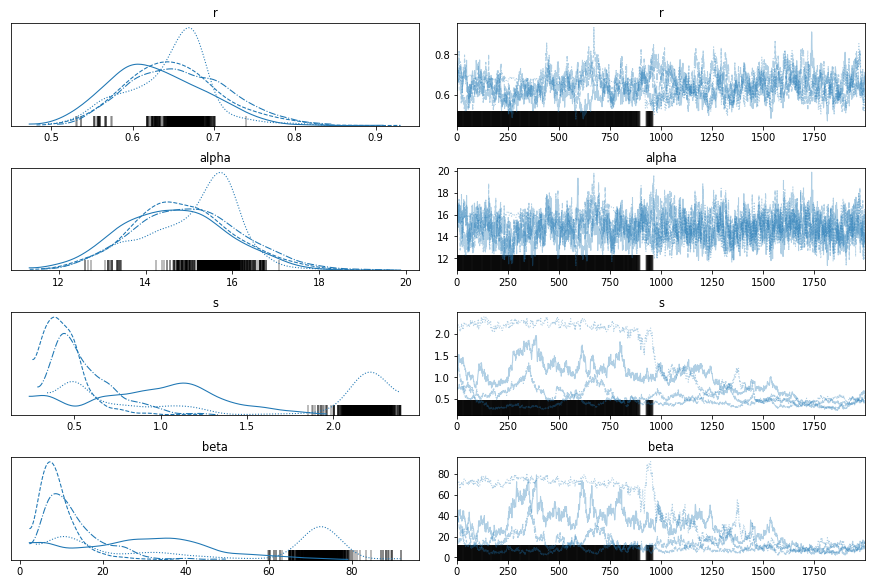

In [25]:
# Traceplots to check for convergence
_ = pm.traceplot(trace, varnames=['r','alpha','s','beta'])

/opt/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


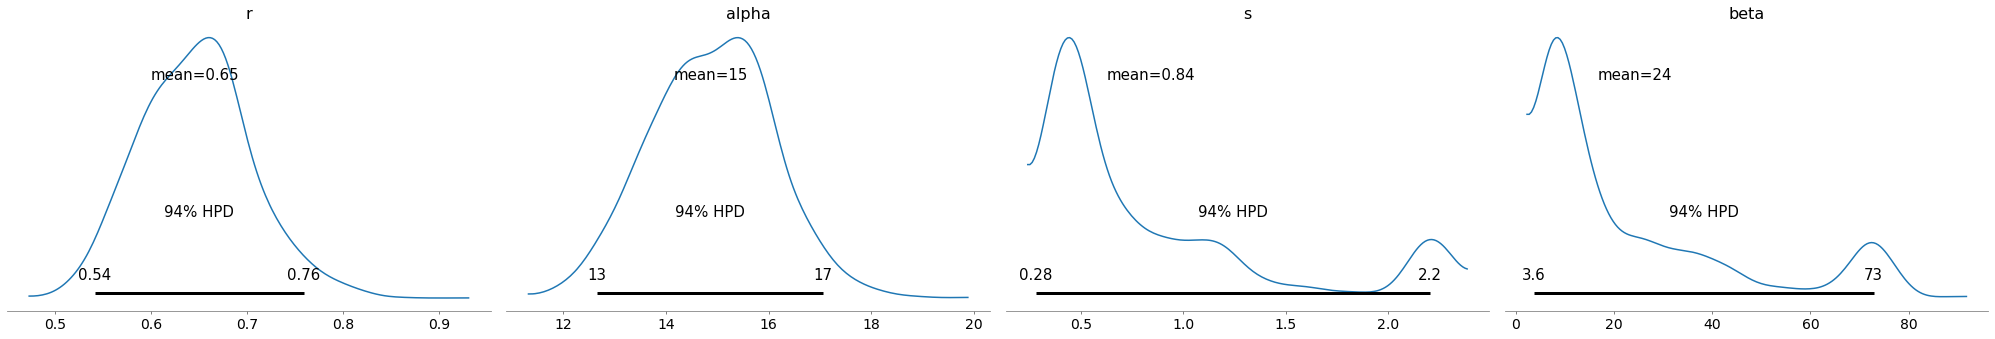

In [26]:
_ = pm.plot_posterior(trace, varnames=['r','alpha','s', 'beta'])

### Key Quantities

Here we provide functions for deriving two key quantities, the probability a customer is still alive at a future period and the expected purchases of a customer in a future period.

#### Probability customer is still alive at time *T*

In [27]:
def prob_alive_at_T(lambda_, mu, t_x, T):
    """
    Probability a customer's time of death \tau occurs after T.
    
    Pr(\tau > T \> | \> \lambda, \mu, x, t_x,T) = \dfrac{1}{1+\dfrac{\mu}{\mu+\lambda}
    \big\{e^{(\lambda+\mu)(T-t_x)}-1\big\}}
    
    See expression (7) in technical appendix of Abe.
    
    :param lambda_: lambda parameter at the customer level :
    :type lambda_: scalar
    :param mu: mu parameter at the customer level
    :type mu_: scalar
    :param t_x: recency of transactions
    :type t_x: float
    :param T: duration of the calibration/training period
    :type T: float
    
    :return: probability of being alive at time T.
    """

    den = 1 + (mu / (lambda_ + mu)) * (np.exp((lambda_ + mu) * (T - t_x)) - 1)
    return 1 / den

#### Cumulative expected purchases for customer in period *(T, T+t)*

In [28]:
def likelihood(lambda_, mu, x, t, T):
    """Pareto/NBD likelihood function.

    :param lambda_: lambda parameter at the customer-level.
    :param mu: mu parameter at the customer level
    :param x: number of repeat transactions
    :param t: recency
    :param T: length of the calibration/training period.

    :return: likelihood value.
    """

    p1 = x * np.log(lambda_) + np.log(mu) - np.log(mu + lambda_) - t * (mu + lambda_)
    p2 = (x + 1) * np.log(lambda_) - np.log(mu + lambda_) - T * (mu + lambda_)
    return np.exp(p1) + np.exp(p2)

def predict(t, lambda_, mu, x, tx, T):
    """Conditional expected purchases at end of time (T, T+t).

    Used to assess holdout period performance and to make predictions
    for future time period t. Conditional on purchase history (x, t_x, T).

    E[X(T,T+t) \> | \> \lambda, \mu, x, t_x, T] = \dfrac{1}{L(\lambda, \mu)|(x, t_x, T)}
    \times \dfrac{\lambda^{x+1}}{\mu}e^{-(\lambda+\mu)T}(1-e^{-\mu t})

    http://brucehardie.com/notes/034/corr_Pareto-NBD.pdf

    :param t: time period
    :type t: scalar

    :param lambda_: lambda parameter at the customer level :
    :type lambda_: scalar

    :param mu: mu parameter at the customer level
    :type mu_: scalar

    :param x: number of repeat transactions
    :type x: integer

    :param tx: recency of transactions
    :type tx: float

    :param T: duration of the calibration/training period
    :type T: float

    :return expected number of purchases (scalar)
    """
    like = likelihood(lambda_, mu, x, tx, T)
    p2 = lambda_ ** (x + 1) / mu * np.exp(-(lambda_ + mu) * T) * (1 - np.exp(-mu * t))

    return 1 / like * p2

<a id="model-checking"></a>
## Model Checking

Here we demonstrate usage of out-of-sample diagnostics to evaluate model performance. In addition, we recommend you evaluate the model based on your own domain experience and any existing models or managerial heuristics you currently employ to measure lifetime value.

### Out-of-sample Evaluation

Lifetimes implements a utility function for summarizing the purchase frequency and time window for an out-of-sample period, typically called the `holdout` period in the literature. In the case of the CDNOW dataset, the holdout period comprises 39 weeks immediately following the end of the calibration period.

In [29]:
from lifetimes.utils import calibration_and_holdout_data

rfm = calibration_and_holdout_data(
    cdnow_transactions, 
    customer_id_col='customer_id',
    datetime_col='date',
    calibration_period_end='1997-09-30',
    observation_period_end='1998-06-30',
    freq='W'
)

rfm.describe()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
count,2357.000000,2357.000000,2357.000000,2357.000000,2357.0
mean,0.940178,6.842597,32.985999,0.758591,39.0
std,1.835391,10.729357,3.346091,1.862830,0.0
min,0.000000,0.000000,27.000000,0.000000,39.0
25%,0.000000,0.000000,30.000000,0.000000,39.0
50%,0.000000,0.000000,33.000000,0.000000,39.0
75%,1.000000,12.000000,36.000000,1.000000,39.0
max,23.000000,39.000000,39.000000,26.000000,39.0


To generate predictions for a user, we take the full posterior distribution of the individual `lambda` and `mu` parameters from the model trace and input them into the `predict` function previously defined. The value of `t` is 39, we have 39 weeks of data following the end of the calibration period. The function returns one prediction for each draw in the Markov chain (2000 in this example) and represents the posterior predictive distribution of future purchases.

### Generating Predictions for a Single Customer

Let's select the 150th user in the dataset and step through the results of model prediction. This customer made two purchases in the calibration period and three purchases in the holdout period.

In [30]:
customer_index = 150
# show purchasing behavior
rfm.iloc[customer_index]

frequency_cal         2.0
recency_cal          17.0
T_cal                38.0
frequency_holdout     3.0
duration_holdout     39.0
Name: 1623, dtype: float64

In [31]:
lambda_post = trace['lambda']
mu_post = trace['mu']

# Select distributions of lambda and mu for a customer
lambda_individual = lambda_post[:,customer_index]
mu_individual = mu_post[:,customer_index]

# predict purchases for the user at t = 39
t = 39
predict(t, lambda_individual, mu_individual, x[customer_index], t_x[customer_index], T[customer_index]).mean()

0.8917840910285378

We underforecast the number of purchases for this customer in the holdout period, but we correctly identified that the customer was still alive.

### Holdout Period Predictions for Entire Customer Cohort

To get a picture of model performance for the entire

In [34]:
holdout_predictions.shape

(2357, 2000)

In [35]:
N

2357

In [36]:
n_draws

2000

In [37]:
# n_draws = 8000

# holdout period is 39 weeks
t = 39
# predictions are size of customer base x number of draws
holdout_predictions = np.empty([N, 8000])

for i in np.arange(N):
    holdout_predictions[i] = predict(
        t, 
        lambda_post[:,i], 
        mu_post[:,i], 
        x[i], 
        t_x[i], 
        T[i]
    )

# predictions are posterior mean
rfm['frequency_predicted'] = holdout_predictions.mean(axis=1)

In the holdout period we predicted 1,724 purchases and observed 1,788.

In [38]:
rfm[['frequency_holdout','frequency_predicted']].sum()

frequency_holdout      1788.000000
frequency_predicted    1606.587487
dtype: float64

The plot below shows the average purchases in the holdout period grouped by the number of repeat purchases made in the calibration period.

In [42]:
import matplotlib.pyplot as plt

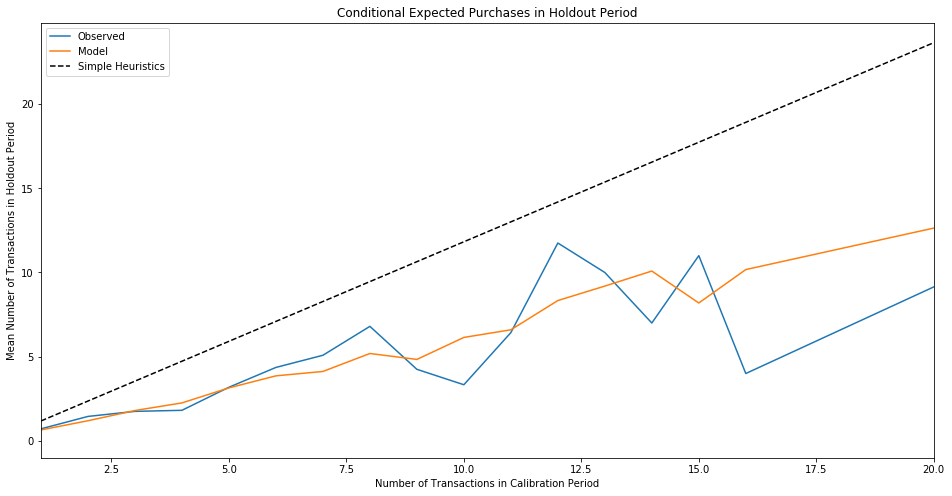

In [43]:
xlim=(1, 20)
mean_frequencies = rfm.groupby('frequency_cal')[['frequency_holdout',
                                     'frequency_predicted']].mean()
mean_frequencies.rename(columns={'frequency_holdout': 'Observed',
                                 'frequency_predicted': 'Model'},
                        inplace=True)
mean_frequencies.plot(kind='line',
                      title='Conditional Expected Purchases in Holdout Period', figsize=(16, 8))

# Generate a dummy model with holdout freq = t_holdout/t_calib
t_calib = np.mean(rfm['T_cal'])
t_holdout = t
x_heuristics = np.linspace(xlim[0],xlim[1],100)
heuristics = t_holdout/t_calib * x_heuristics

plt.plot(x_heuristics, heuristics, linestyle='--', color='black', label='Simple Heuristics')
plt.legend(loc=0)
plt.xlim(xlim)
plt.ylabel('Mean Number of Transactions in Holdout Period')
plt.xlabel('Number of Transactions in Calibration Period')
plt.grid(False)
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error
print("RMSE: %s" % np.sqrt(mean_squared_error(rfm['frequency_holdout'], rfm['frequency_predicted'])))

RMSE: 1.42028772097679


Additional model diagnostics are typically included in papers describing models. 

<a id="further-reading"></a>
## Further Reading

Probabilistic models are popular in the customer lifetime value literature. The following are a list of papers for further reading:

* Counting Your Customers The Easy Way, Peter S. Fader and Bruce Hardie, http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf
* Counting Your Customers One By One, A Hierarchical Bayes Extension to the Pareto/NBD Model, Shinzo Abe, http://pubsonline.informs.org/doi/abs/10.1287/mksc.1090.0502?journalCode=mksc
* Customer Lifetime Value Measurement, Shazad Borle, Siddarth Singh, and Dipak Jain, http://pubsonline.informs.org/doi/abs/10.1287/mnsc.1070.0746?journalCode=mnsc

Bayesian Analysis Textbooks

* Doing Bayesian Data Analysis, John Kruschke
* Statistical Rethinking, Richard McElreath
* Bayesian Data Analysis, Andrew Gelman